In [1]:
#vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
# These sections are encouraged to be altered! (Of course, you can change all of the code!)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

## Notebook setup

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from clawpack.clawutil import nbtools
from clawpack.visclaw import animation_tools
from IPython.display import HTML
from PIL import Image
import os
import shutil
import glob
from distutils.dir_util import copy_tree

In [4]:
nbtools.make_exe(new=True,verbose=False)

Check save path

In [5]:
if os.path.isdir('_saved') == False:
    os.mkdir('_saved')
elif os.path.isdir('_saved/_plots') == False:
    os.mkdir('_saved/_plots')
elif os.path.isdir('_saved/_anim') == False:
    os.mkdir('_saved/_anim')

### Functions

Function to display animation

In [6]:
def show_anim(anim, form = 5):
    if form == 5:
        html_version = HTML(anim.to_html5_video())
    elif form == 'js':
        html_version = HTML(anim.to_jshtml())
    else:
        print("animation type not recognised, defaulting to HTML5 video")

    return html_version

Function to write (any changes made by the user to) \*.data files, and then run the code from these files to create fortran data and images to be used in animation. 

In [7]:
def compiler(rundata, element, comp_manns, out = False):
    # create *.data files from parameters in setrun.py
    rundata.write()
    # Run the code from the *.data files
    nbtools.make_output_and_plots(label="_{}".format(element), verbose = out)
    print("File {} out of {} compiled".format(comp_manns.index(element) + 1, len(comp_manns)))

Function to concatenate frames to be used in animation, then creating the user-facing animation. 

In [8]:
def stitch_anim(anim_manns, amount_manns, choose_manns, exno = 1, figno = 0, form = 5):

    old_frames = glob.glob('_plots/*')
    for f in old_frames:
        os.remove(f)
        
    if exno == 1:
        frames = 5
        extra = ''
    elif exno == 2:
        frames = 19
        extra = 0
    else:
        print ("Error : Enter the exercise you are running, either 1, or 2")
        
    for a in range(exno - 1 ,frames + 1):
        im = Image.open('_plots_{}/frame{:04d}fig{}.png'.format(anim_manns[0],a, figno))
        im_alt = Image.open('_plots_{}/frame{:04d}fig{}.png'.format(anim_manns[1], a, figno))
        dst = Image.new('RGB', (im.width + im_alt.width, im.height))
        dst.paste(im, (0, 0))
        dst.paste(im_alt, (im.width, 0))
        dst.save('_plots/frame{:04d}fig{}.png'.format(a, figno))
        

    anim = animation_tools.animate_from_plotdir('_plots', figno)
    
    if os.path.isdir("_saved/_anim/ex_{}-fig_{}-manns_{}".format(exno, figno, anim_manns)) == False:
        os.mkdir("_saved/_anim/ex_{}-fig_{}-manns_{}".format(exno, figno, anim_manns))
        copy_tree("_plots", "_saved/_anim/ex_{}-fig_{}-manns_{}".format(exno, figno, anim_manns))

    print('\nMannings n = {} on left animation, and n = {} on right '\
          'animation'.format(choose_manns[anim_manns[0]], choose_manns[anim_manns[1]]))
    
    return show_anim(anim, form)

Clear old data files and diretories

In [9]:
for k in range(1,11):
    try:
        os.remove('setrun_{}.py'.format(k))
        os.remove('plot_output_{}.txt'.format(k))
        os.remove('run_output_{}.txt'.format(k))
        shutil.rmtree('_plots_{}'.format(k))
        shutil.rmtree('_output_{}'.format(k))
    except Exception:
        pass

## Edit mannings values

Custom mannings values

Note : All manning values are shown in their absolute value (the program does not display negative values any differently from positive ones)

In [10]:
geoclaw_tsunami = 0.025
yanigasawa_koshimura_2009_mangrove = 0.04
test = 10

In [11]:
choose_manns = {}

# Choose purpose of current data complation
#vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
plot_family = True
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 
if plot_family == True:
    # Plot family of curves around a specified middle mannings value
    #vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    amount_manns = 10
    mid_mann = 2
    space_manns = 0.4
    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    manns = [None] * amount_manns

        
elif plot_family == False: 
    #vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    manns = [test, geoclaw_tsunami]
    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    amount_manns = len(manns)
    
for k in range (amount_manns):
    if plot_family == True:
        if amount_manns%2 == 0:
            manns[k] = abs(mid_mann + (k + 1 - (amount_manns)/2) * space_manns)
        else:
            manns[k] = abs(mid_mann + (k + 1 - (amount_manns + 1) /2) * space_manns)
            
    choose_manns[k+1] = manns[k] 
    
    os.system("cp setrun.py setrun_{}.py".format(k + 1)) # LinuxOS command : copies 'setrun.py' and pastes it as renamed 'setrun_#'.py

anim_manns = [None] * 2
if len(choose_manns) > 2:
    anim_manns[0] = int(input('Choose (1-{}) the first mannings values to'\
                          ' compare via animation: {}\n'.format(amount_manns, choose_manns)))
    anim_manns[1] = int(input('Choose (1-{}) the second mannings values to'\
                          ' compare via animation: {}\n'.format(amount_manns, choose_manns)))
else:
    print('Mannings values to be compiled : {}\n'.format(manns))
    anim_manns[0] = 1
    anim_manns[1] = 2

Choose (1-10) the first mannings values to compare via animation: {1: 0.3999999999999999, 2: 0.7999999999999998, 3: 1.2, 4: 1.6, 5: 2.0, 6: 2.4, 7: 2.8, 8: 3.2, 9: 3.6, 10: 4.0}
 5
Choose (1-10) the second mannings values to compare via animation: {1: 0.3999999999999999, 2: 0.7999999999999998, 3: 1.2, 4: 1.6, 5: 2.0, 6: 2.4, 7: 2.8, 8: 3.2, 9: 3.6, 10: 4.0}
 1


## Initiate and write changes to data files

In [12]:
def init_comp(exno, anim123 = False, plots = False):
    if plots == True:
        comp_manns = range(1, amount_manns + 1)
    # If user is not going to plot curves, only 2 manning's values are neccessary to be compiled
    elif plots == False:
#         comp_manns = [number - 1 for number in anim_manns]
        comp_manns = anim_manns
     
    for element in comp_manns:
        mod = importlib.import_module("setrun_{}".format(element))
        rundata = mod.setrun()
        # Changes to the original setrun.py
        #---------------------------------------
        # Change Mannings
        rundata.geo_data.manning_coefficient = manns[element - 1]
        # Change output times:
        rundata.clawdata.output_style = exno #This is the difference from ex1 to ex2 in the animation
        rundata.clawdata.output_times = linspace(3.5,8,19) * 3600.
            # Change gauge location:
        from clawpack.amrclaw.data import GaugeData
        rundata.replace_data("gaugedata", GaugeData())  # clear old gauge data
        rundata.gaugedata.gauges = []   # empty list

        rundata.gaugedata.gauges.append([32412, -86.392, -17.975, 0., 1.e10]) # original gauge
        rundata.gaugedata.gauges.append([123, -77.3, -12.3, 3.5*3600, 1.e10]) # relocated gauge
        if anim123 == False:
            for j in range(len(dict_loc)):
                rundata.gaugedata.gauges.append([j, long[j], lat[j], 0., 1.e10]) # not currently close to epicentre gauge
        #---------------------------------------
        compiler(rundata, element, comp_manns)

## Edit location of gauges

custom locations to plot gauges at:

area wave resides in first hour [-85,-72,-38,-25]

In [13]:
dict_loc = {'southwest of epicenter':[-76,-40],
            'epicenter':[-72.733,-34.909], 
            'between Alejandro Selkirk Island and epicenter ':[-77.039874, -34.917790]}

long = [None] * len(dict_loc)
lat = [None] * len(dict_loc)

for key in dict_loc:
    k = list(dict_loc).index(key)
    loc = dict_loc[key]
    long[k] = loc[0]
    lat[k] = loc[1]

# Animations

## North east section

In [14]:
exno = 2
figno = 1

init_comp(exno, anim123 = True)    
stitch_anim(anim_manns, amount_manns, choose_manns, exno, figno, 'js')

File 1 out of 2 compiled
File 2 out of 2 compiled

Mannings n = 2.0 on left animation, and n = 0.3999999999999999 on right animation


## Full map

You can use this animation to check your gauges are positioned correctly

In [15]:
exno = 1
init_comp(exno)
figno = 0
stitch_anim(anim_manns, amount_manns, choose_manns, exno, figno, 'js')

File 1 out of 2 compiled
File 2 out of 2 compiled

Mannings n = 2.0 on left animation, and n = 0.3999999999999999 on right animation


# Gauge plots

In [16]:
exno = 2
figno = 1

if exno == 1:
    raise Exception("You need to run exercise number 2 with all gauge plots"\
                    " compiled to view the plots correctly. Please run the"\
                    " cell above this error and then continue running the notebook")

init_comp(exno, plots = True)

File 1 out of 10 compiled
File 2 out of 10 compiled
File 3 out of 10 compiled
File 4 out of 10 compiled
File 5 out of 10 compiled
File 6 out of 10 compiled
File 7 out of 10 compiled
File 8 out of 10 compiled
File 9 out of 10 compiled
File 10 out of 10 compiled


## Import gauge data

In [18]:
from setplot import setplot
plotdata = setplot()

#vvvvvvvvvvvvvvv
custom_gauge = 1 # this is the gauge corresponding to the n-entry in dict_loc
#^^^^^^^^^^^^^^^

h777 = [None] * (amount_manns)
u777 = [None] * (amount_manns)
v777 = [None] * (amount_manns)
t777 = [None] * (amount_manns)
eta777 = [None] * (amount_manns)

h123 = [None] * (amount_manns)
u123 = [None] * (amount_manns)
v123 = [None] * (amount_manns)
t123 = [None] * (amount_manns)
eta123 = [None] * (amount_manns)

h32412 = [None] * (amount_manns)
u32412 = [None] * (amount_manns)
v32412 = [None] * (amount_manns)
t32412 = [None] * (amount_manns)
eta32412 = [None] * (amount_manns)


for k in range(amount_manns):
    plotdata.outdir = '_output_{}'.format(k + 1)
    # get gauge 123 data
    g123 = plotdata.getgauge(123)
    t123[k] = g123.t / 3600.  # convert to hours
    eta123[k] = g123.q[3,:]   # eta = h + B (depth plus bathymetry)
    h123[k] = g123.q[0,:]       # water depth
    u123[k] = g123.q[1,:] / h123[k]  # u = east-west velocity
    v123[k] = g123.q[2,:] / h123[k]  # v = north-south velocity
    
    # get gauge 32412 data
    g32412 = plotdata.getgauge(32412)
    t32412[k] = g32412.t / 3600.  # convert to hours
    eta32412[k] = g32412.q[3,:]   # eta = h + B (depth plus bathymetry)
    h32412[k] = g32412.q[0,:]       # water depth
    u32412[k] = g32412.q[1,:] / h32412[k]  # u = east-west velocity
    v32412[k] = g32412.q[2,:] / h32412[k]  # v = north-south velocity
    
    g777 = plotdata.getgauge(1)
    t777[k] = g777.t / 3600.  # convert to hours
    eta777[k] = g777.q[3,:]   # eta = h + B (depth plus bathymetry)
    h777[k] = g777.q[0,:]       # water depth
    u777[k] = g777.q[1,:] / h777[k]  # u = east-west velocity
    v777[k] = g777.q[2,:] / h777[k]  # v = north-south velocity

colour = ['#fc0303', '#f59042', '#f5ce42', '#d7f542', 
          '#90f542', '#48f542', '#42f59c', '#42ddf5', 
          '#4272f5', '#8a42f5']
# for k in range(amount_manns):
#     contrast = (k*3) % 10
#     colour[k] = colour[contrast]

*** Could not load DART data file
Read in gauge 123.
Read in gauge 32412.
Read in gauge 1.
Read in gauge 123.
Read in gauge 32412.
Read in gauge 1.
Read in gauge 123.
Read in gauge 32412.
Read in gauge 1.
Read in gauge 123.
Read in gauge 32412.
Read in gauge 1.
Read in gauge 123.
Read in gauge 32412.
Read in gauge 1.
Read in gauge 123.
Read in gauge 32412.
Read in gauge 1.
Read in gauge 123.
Read in gauge 32412.
Read in gauge 1.
Read in gauge 123.
Read in gauge 32412.
Read in gauge 1.
Read in gauge 123.
Read in gauge 32412.
Read in gauge 1.
Read in gauge 123.
Read in gauge 32412.
Read in gauge 1.


In [19]:
if os.path.isdir('_saved/_plots/manns_{}'.format(manns)) == False:
    os.mkdir('_saved/_plots/manns_{}'.format(manns))

## Gauge 123

In [20]:
gauge = 123

### Velocity

In [21]:
measure = 'velocity'

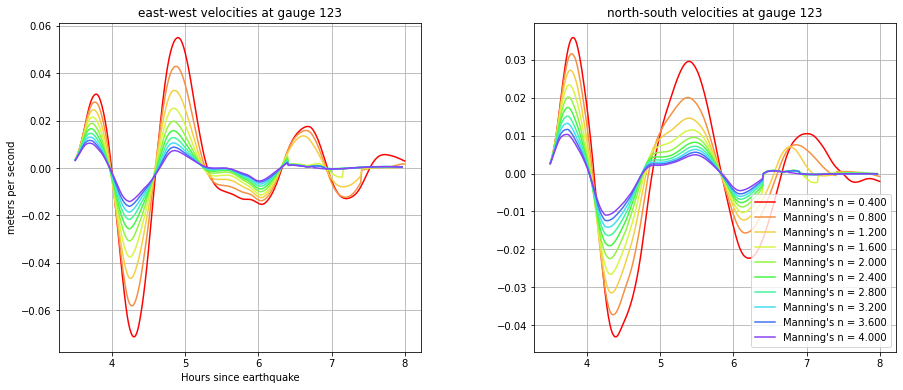

In [22]:
subplot(1, 2, 1)
grid()
for k in range(amount_manns):
    plot(t123[k],u123[k], color = colour[k], label="Manning's n = {:.3f}".format(manns[k]))   
xlabel('Hours since earthquake')
ylabel('meters per second')
title('east-west velocities at gauge 123')

subplot(1, 2, 2)
grid()
for k in range(amount_manns):
    plot(t123[k],v123[k], color = colour[k], label="Manning's n = {:.3f}".format(manns[k]))   
legend()
title('north-south velocities at gauge 123')

tight_layout()
gcf().set_size_inches(14,6)
savefig('_saved/_plots/manns_{}/gauge_{}-measure_{}.png'.format(manns, gauge, measure))

show()

### Height

In [23]:
measure = 'height'

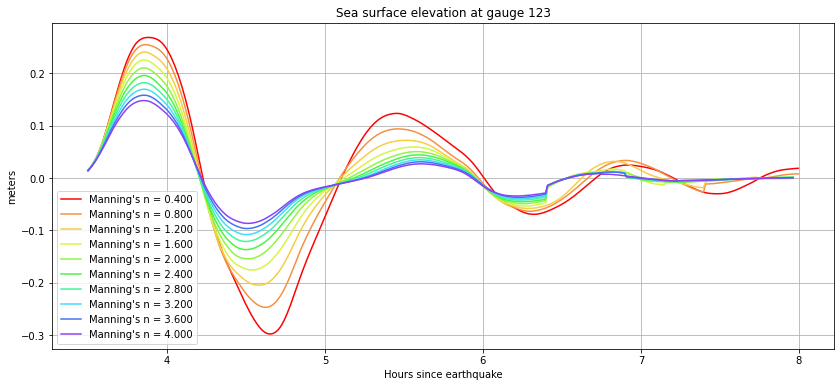

In [24]:
grid()
for k in range(amount_manns):
    plot(t123[k],eta123[k], color = colour[k], label="Manning's n = {:.3f}".format(manns[k]))
legend()
xlabel('Hours since earthquake')
ylabel('meters')
title('Sea surface elevation at gauge 123')

gcf().set_size_inches(14,6)
savefig('_saved/_plots/manns_{}/gauge_{}-measure_{}.png'.format(manns, gauge, measure))
show()

## Gauge 777

In [25]:
gauge = list(dict_loc.keys())[custom_gauge]
print(gauge)

epicenter


### Velocity

In [26]:
measure = 'velocity'

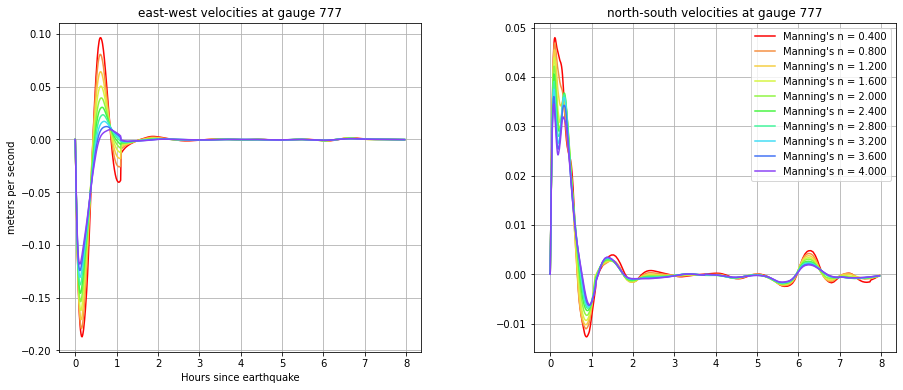

In [27]:
subplot(1, 2, 1)
grid()
for k in range(amount_manns):
    plot(t777[k],u777[k], color = colour[k], label="Manning's n = {:.3f}".format(manns[k]))   
xlabel('Hours since earthquake')
ylabel('meters per second')
title('east-west velocities at gauge 777')

subplot(1, 2, 2)
grid()
for k in range(amount_manns):
    plot(t777[k],v777[k], color = colour[k], label="Manning's n = {:.3f}".format(manns[k]))   
legend()
title('north-south velocities at gauge 777')

tight_layout()
gcf().set_size_inches(14,6)
savefig('_saved/_plots/manns_{}/gauge_{}-measure_{}.png'.format(manns, gauge, measure))
show()

## Height

In [28]:
measure = 'height'

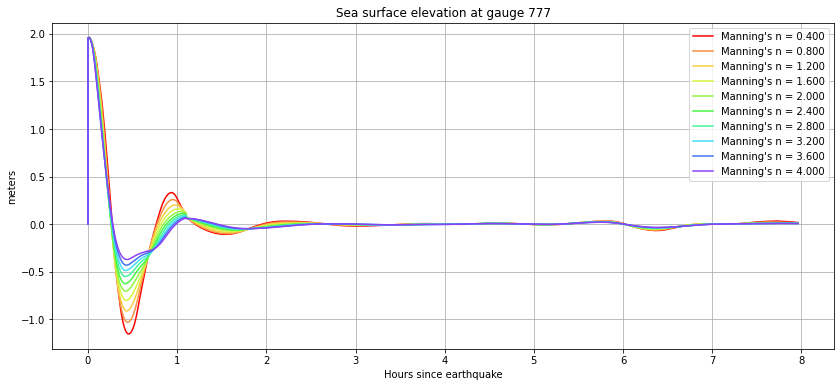

In [29]:
grid()
for k in range(amount_manns):
    plot(t777[k],eta777[k], color = colour[k], label="Manning's n = {:.3f}".format(manns[k]))
legend()
xlabel('Hours since earthquake')
ylabel('meters')
title('Sea surface elevation at gauge 777')

gcf().set_size_inches(14,6)
savefig('_saved/_plots/manns_{}/gauge_{}-measure_{}.png'.format(manns, gauge, measure))
show()

## Gauge 32412

In [30]:
gauge = 32412

### Velocity

In [31]:
measure = 'velocity'

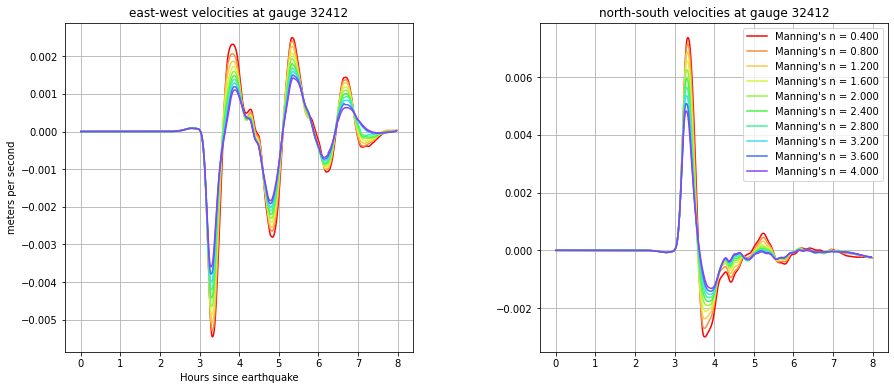

In [32]:
subplot(1, 2, 1)
grid()
for k in range(amount_manns):
    plot(t32412[k],u32412[k], color = colour[k], label="Manning's n = {:.3f}".format(manns[k]))   
xlabel('Hours since earthquake')
ylabel('meters per second')
title('east-west velocities at gauge 32412')

subplot(1, 2, 2)
grid()
for k in range(amount_manns):
    plot(t32412[k],v32412[k], color = colour[k], label="Manning's n = {:.3f}".format(manns[k]))   
legend()
title('north-south velocities at gauge 32412')

tight_layout()
gcf().set_size_inches(14,6)
savefig('_saved/_plots/manns_{}/gauge_{}-measure_{}.png'.format(manns, gauge, measure))
show()

### Height (against real life data)

In [33]:
measure = 'height'

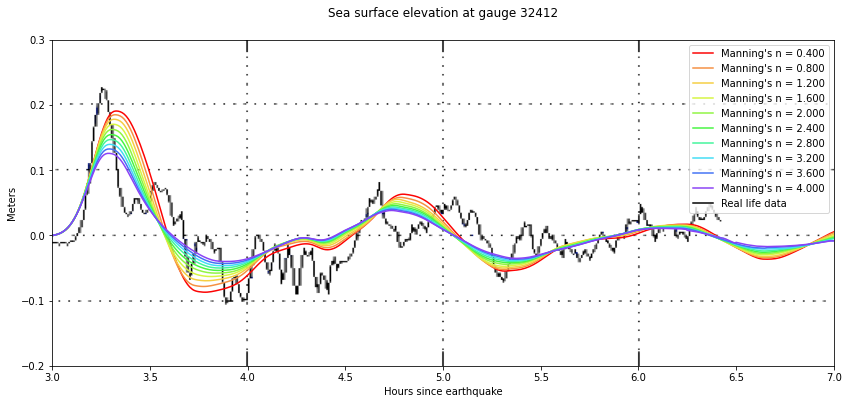

In [37]:
ax = gca()
 
# ax.set_prop_element(color=colour) 

xmin, xmax, ymin, ymax = (3, 7, -0.20, 0.30)

for k in range(amount_manns):
    ax.plot(t32412[k],eta32412[k], color = colour[k], label="Manning's n = {:.3f}".format(manns[k]))
ax.plot(0,0,color='k', label="Real life data")
ax.legend()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Hours since earthquake')
ax.set_ylabel('Meters')
ax.set_title('Sea surface elevation at gauge 32412')

ax.set_zorder(2)
ax.set_facecolor('none')

ax_tw_x = ax.twinx()
ax_tw_x.axis('off')
ax2 = ax_tw_x.twiny()

im = imread('gauge32412-actual-detide.png')
ax2.imshow(im, extent=[xmin, xmax, ymin, ymax], aspect='auto')
ax2.axis('off')

gcf().set_size_inches(14,6)
savefig('_saved/_plots/manns_{}/gauge_{}-measure_{}.png'.format(manns, gauge, measure))
show()

# TESTING AREA

Notes :
- Save plots and animations (can I use the anim. in the first function? like anim.save?)
- Write figure legends
- Use G123 data to test different values given in the paper for areas such as forests,
    importance of mangrove trees was undervalued
- colours need to have more distinction

In [ ]:
# from PIL import Image
# from distutils.dir_util import copy_tree
# if os.path.isdir('_saved') == False:
#     os.mkdir('_saved')
# def stitch_save_anim(choose_manns, anim_manns, exno = 1, figno = 0):
#     os.system("mkdir _plots")
    
#     if exno == 1:
#         frames = 5
#         extra = ''
#     elif exno == 2:
#         frames = 19
#         extra = 0
#     else:
#         print ("Error : Enter the exercise you are running, either 1, or 2")
        
#     for a in range(exno - 1 ,frames + 1):
#         im = Image.open('_plots_{}/frame{:04d}fig{}.png'.format(anim_manns[0],a, figno))
#         im_alt = Image.open('_plots_{}/frame{:04d}fig{}.png'.format(anim_manns[1], a, figno))
#         dst = Image.new('RGB', (im.width + im_alt.width, im.height))
#         dst.paste(im, (0, 0))
#         dst.paste(im_alt, (im.width, 0))
#         dst.save('_plots/frame{:04d}fig{}.png'.format(a, figno))
#         source = '_plots/'
#         dest = '_saved/mann_{}_{}-ex{}-fig{}'.format(choose_manns[anim_manns[0]]\
#                                                      ,choose_manns[anim_manns[1]],1,0)
#         copy_tree(source, dest)
        
# #         animation_tools.animate_from_plotdir('_plots', figno)
# #     print('\nMannings n = {} on left animation, and n = {} on right '\
# #           'animation'.format(choose_manns[anim_manns[0]], choose_manns[anim_manns[1]]))
# #     return show_anim(anim)
                  
# for j in range (3):
#     for k in range (amount_manns):
#         mod = importlib.import_module("setrun_{}".format(k+1))
#         rundata = mod.setrun()
#         # Variables to change
#         #vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
#         # Change Mannings
#         rundata.geo_data.manning_coefficient = manns[k]
#         # Change output times:
#         if j == 2:
#             rundata.clawdata.output_style = 2 #This is the difference from ex1 to ex2 in the animation
#             rundata.clawdata.output_times = linspace(3.5,8,19) * 3600.
#             # Change gauge location:
#             from clawpack.amrclaw.data import GaugeData
#             rundata.replace_data("gaugedata", GaugeData())  # clear old gauge data
#             rundata.gaugedata.gauges = []   # empty list
#             rundata.gaugedata.gauges.append([32412, -86.392, -17.975, 0., 1.e10]) # original gauge
#             rundata.gaugedata.gauges.append([123, -77.3, -12.3, 3.5*3600, 1.e10]) # relocated gauge
#         #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#         compiler(k, amount_manns)
#     if j < 2:
#         stitch_save_anim(choose_manns, anim_manns,1,j)
#     else:
#         stitch_save_anim(choose_manns, anim_manns,2,1)

In [ ]:
# tot_gauges = (len(dict_loc) + 2)

# g = h = u = v = t = eta = [None] * tot_gauges

# for j in range(tot_gauges): 
#     h[j] = u[j] = v[j] = t[j] = eta[j] = [None] * amount_manns
    
#     print(t[0][0])
    
#     for k in range(amount_manns):
#         plotdata.outdir = '_output_{}'.format(k + 1)
#         # get gauge 123 data
# #         if j + 2 == tot_gauges:
#         g[j] = plotdata.getgauge(123)
# #         elif j + 1 == tot_gauges:
# #             g[j] = plotdata.getgauge(32412)
# #         else:
# #             g[j] = j
#         print(g[j].t/ 3600.)   
        
#         t[j][k] = g[j].t / 3600.  # convert to hours
#         eta[j][k] = g[j].q[3,:]   # eta = h + B (depth plus bathymetry)
#         h[j][k] = g[j].q[0,:]       # water depth
#         u[j][k] = g[j].q[1,:] / h[j][k]  # u = east-west velocity
#         v[j][k] = g[j].q[2,:] / h[j][k]  # v = north-south velocity